Module 3 Project: Hypothesis testing with Northwind database

Name: Bonnie Ma

Methodology Used: Independent T-Test, Welch's T-Test, Mann Whitney U Test, ANOVA, Central Limit Theorem


Process:
    - Explore the data
    - Develop hypothesis
    - Hypothese test
    - Interpret the results

### Import the librabries 

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm


%matplotlib inline


In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
cur.execute(
"""
SELECT name from sqlite_master
WHERE type="table";
""")

In [4]:
cur.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

### Define Functions

In [5]:
def sql_with_cols(query,cursor=cur):
  
  result = cursor.execute(query).fetchall()
  cols = tuple([description[0] for description in cur.description])
  
  full_result = (cols, result[:])
  return full_result

def df_sql(query, cursor=cur):
    cols, result_data = sql_with_cols(query, cursor)
    return pd.DataFrame(data=result_data, columns=cols)

In [6]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [7]:
#Two sample T-Test
#def two_sample_ttest(a, b)

In [8]:
#Welch's T Test for Samples with different variances
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """
    
    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    t = np.abs(numerator/denominator)
    
    return t

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    df = numerator/denominator
    
    return round(df, 0)
   
     #Return the degrees of freedom

def welch_t_p_value(a, b, two_sided=False):
    
    t = welch_t(a,b)
    df = welch_df(a,b)
    
    p = 1 - stats.t.cdf(t, df)
    
    if two_sided:
        return 2*p
    else:
        return p
    

### Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### 1.1 Hypothesis Statement 

$H_0$: Discount amount does **not** have a significant effect on the quantity of a product in an order<br>

$H_a$: Discount amount does have a significant effect on the quantity of a product in an order<br>

Significant level = 95%, alpha = 0.05

### 1.2 Data Exploration

In [9]:
discount = df_sql(
"""
SELECT * FROM OrderDetail

""")

Different levels of discount can be categoried into 5 levels based on frequency: 0%, 5%, 10%, 15%, 20%, 25%0%.
First we examine no discount at all with at least some level of discount; Secondly, we can run Anova tests on different levels and understand which level has the most impact.

In [10]:
discount.groupby("Discount")['Quantity'].count()

Discount
0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Quantity, dtype: int64

In [11]:
df = df_sql("""
SELECT OrderId, Sum(Quantity) as quantity, Avg(Discount) as avg_dis FROM OrderDetail

GROUP BY OrderId;

""")
df.head()

,OrderId,quantity,avg_dis
0,10248,27,0.000000
1,10249,49,0.000000
2,10250,60,0.100000
3,10251,41,0.033333
4,10252,105,0.033333


In [12]:
#A: NO DISCOUNT
#B: HAS DISCOUNT
df_nodiscount = df[df['avg_dis']==0]

df_discount= df[df['avg_dis']>0]

In [13]:
a=df_nodiscount['quantity']
a.mean()

52.44

In [14]:
b=df_discount['quantity']
b.mean()

72.94473684210526

In [15]:
def visualization(control, experimental):
    plt.figure(figsize=(10,6))
    sns.distplot(experimental, bins=50,  label='Avg Quantity w/ Discount', color='green')
    sns.distplot(control, bins=50,  label='Avg Quantity w/o Discount', color='blue')

    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--')

    plt.title('Discount vs Non-Discount', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


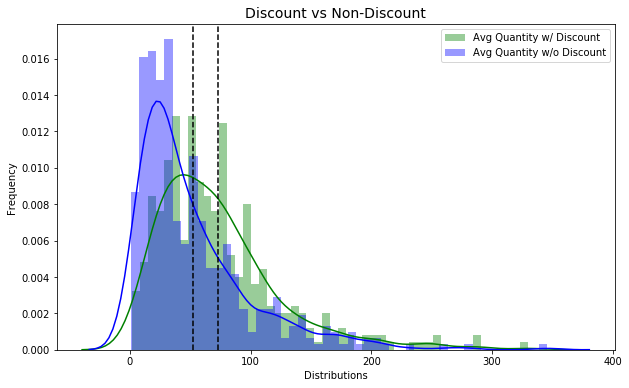

In [16]:
visualization(a, b)

Discount and Non-Discount distributions do not seem to be normally distributed, however, since the sample size is large enough (>30), we can still use T-Test on sample means based on Central Limit Theorem. 

But we still need to test the equality of variance to decide if 2 sample T-Test or Welch's T-Test should be used. 

### 1.3 Hypothesis Test

### Test of Equal Variance

Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

In [17]:
stats.levene(a, b, center='mean')

LeveneResult(statistic=1.0369358925445291, pvalue=0.30883261672605483)

The Pvalue is 0.3088 > alpha(0.05), so we can not reject the null hypothesis that both samples are from populations with equal variance. Therefore, we can use two sample t test in this case.

### 2 Sample Independent T-Test

In [18]:
stats.ttest_ind(a, b, equal_var=True)

Ttest_indResult(statistic=-5.91731561103876, pvalue=4.7876655924928625e-09)

#### Non Parametric KS Test

In [19]:
#compare the distributions
stats.ks_2samp(a,b)

Ks_2sampResult(statistic=0.26900584795321636, pvalue=1.3184694069188487e-13)

#### Mann-Whitney Test

In [20]:
#Non Parametric equivalent of t tests
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=59105.0, pvalue=8.524065415288705e-15)

In [21]:
#Confidence level of 95%
alpha = 0.05

#### Conclusion: Since pvalue is smaller than alpha, we reject the null. There is significant effect on product quantity when discount exists. 

#### Effect Size

In [22]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [23]:
abs(Cohen_d(a,b))

0.4122521666326047

#### Cohen's D shows the difference is small to medium

### Next examine whether different levels of discount have different impact on quantity volume

$H_0$: There is **no** significant difference in impact on quantity between discount levels <br>

$H_a$: There is significant difference in impact on quantity between at least one discount levels<br>

Significant level = 95%, alpha = 0.05


In [24]:
discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


Data Exploration

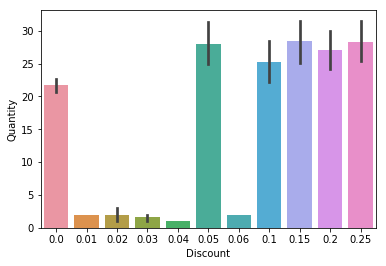

In [25]:
ax = sns.barplot(x="Discount", y="Quantity", data=discount)

Only keep 5%, 10%, 15%, 20%, 25%

**Data Transformation**

In [26]:
discount1 = discount.pivot(columns='Discount',values='Quantity') 

In [27]:
discount1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 11 columns):
0.0     1317 non-null float64
0.01    1 non-null float64
0.02    2 non-null float64
0.03    3 non-null float64
0.04    1 non-null float64
0.05    185 non-null float64
0.06    1 non-null float64
0.1     173 non-null float64
0.15    157 non-null float64
0.2     161 non-null float64
0.25    154 non-null float64
dtypes: float64(11)
memory usage: 202.0 KB


In [29]:
discount2 = discount1.drop(columns={0.01,0.02,0.03,0.04,0.06})

In [30]:
discount2 = discount1.rename(columns={0.0:"A",0.05:"B",0.1:"C",0.15:"D",0.2:"E",0.25:"F"})

In [31]:
discount2.head()

Discount,A,0.01,0.02,0.03,0.04,B,0.06,C,D,E,F
0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
A = discount2['A'].dropna()
B = discount2['B'].dropna()
C = discount2['C'].dropna()
D = discount2['D'].dropna()
E = discount2['E'].dropna()
F = discount2['F'].dropna()

### Test for equality of variances for 5 discount groups

In [33]:
stats.levene(B,C,D,E,F)

LeveneResult(statistic=0.2092544330590371, pvalue=0.9333364288844539)

Since Pvalue > alpha (0.05), we can not reject the null which believes samples are from population with equal variance. We can use ANOVA test.

#### Use stats.f_oneway 

In [34]:
f_stat, p_value = stats.f_oneway(B,C,D,E,F)
print('F-stat:',f_stat)
print('p-value:',p_value)

F-stat: 0.6741032559876151
p-value: 0.610041445360832


#### Use multiple linear regression

In [35]:
df = df_sql(
"""
SELECT * FROM OrderDetail
WHERE Discount IN (0.05, 0.1, 0.15, 0.2, 0.25);

""")

In [36]:
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


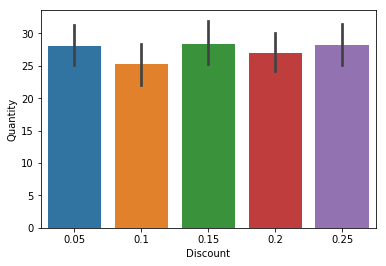

In [37]:
ax = sns.barplot(x='Discount', y='Quantity', data = df)

In [38]:
df['Discount'] = df['Discount'].astype('category')

In [39]:
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [41]:
results = ols('Quantity ~ Discount', data=df).fit()

table = sm.stats.anova_lm(results, typ=1)

print(table)

             df         sum_sq     mean_sq         F    PR(>F)
Discount    4.0    1159.517551  289.879388  0.674103  0.610041
Residual  825.0  354768.342690  430.022234       NaN       NaN


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 0.05   0.1   -2.7738  -8.7696 3.222  False 
 0.05   0.15   0.3714  -5.7803 6.523  False 
 0.05   0.2    -0.986  -7.0962 5.1242 False 
 0.05   0.25   0.2294  -5.9546 6.4134 False 
 0.1    0.15   3.1452  -3.1037 9.394  False 
 0.1    0.2    1.7879  -4.4202 7.9959 False 
 0.1    0.25   3.0033  -3.2774 9.2839 False 
 0.15   0.2   -1.3573   -7.716 5.0014 False 
 0.15   0.25  -0.1419  -6.5715 6.2877 False 
 0.2    0.25   1.2154  -5.1745 7.6054 False 
--------------------------------------------


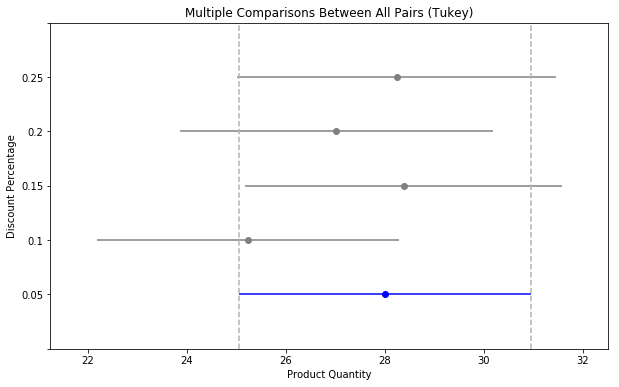

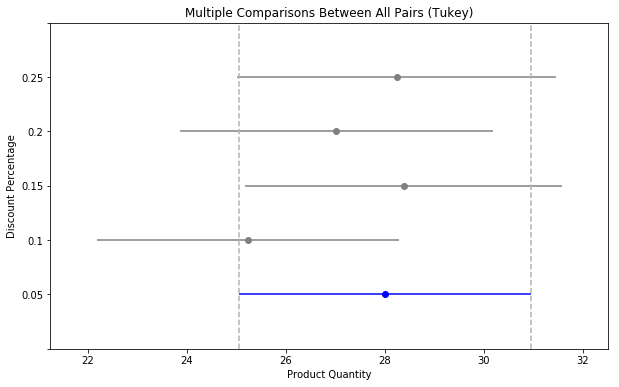

In [42]:
#Do Tukey's after Anova, Tukey makes your alpha even smaller.
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

com = MultiComparison(df['Quantity'],df['Discount'])
tukey = com.tukeyhsd()
print(tukey.summary())
tukey.plot_simultaneous(comparison_name = 0.05, figsize=(10,6), ylabel='Discount Percentage', xlabel='Product Quantity')

### 1.4 Result Intepretation

- There is significant difference between Discount vs Non Discount
- There is no signicant difference among different discount levels

## Question 2: Does different regions perform the same?

- Do they generate the same revenue? 
- Does discount have same impact on each region?
- Does Freight differ from region to region?

### 2.1 Hypothesis Development

$H_0$: The average revenue per customer is **NOT** different across regions<br>

$H_a$: The average revenue per customer **IS** different across regions<br>

Significant level = 95%, alpha = 0.05

### 2.2 Data Exploration

Join Order and OrderDetail to get total revenue from all regions

In [162]:
customer = df_sql(
"""
SELECT * FROM Customer

       """)

In [163]:
customer.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [164]:
df = df_sql(
"""
SELECT O.CustomerID, C.Region, D.UnitPrice, D.Quantity, D.Discount  FROM Customer C
JOIN 'Order' O
ON C.ID = O.CustomerId
JOIN OrderDetail D
ON D.OrderId = O.Id

       """)

In [165]:
df.head()

,CustomerId,Region,UnitPrice,Quantity,Discount
0,VINET,Western Europe,14.0,12,0.0
1,VINET,Western Europe,9.8,10,0.0
2,VINET,Western Europe,34.8,5,0.0
3,TOMSP,Western Europe,18.6,9,0.0
4,TOMSP,Western Europe,42.4,40,0.0


In [166]:
df['Revenue']=df['Quantity']*df['UnitPrice']*(1-df['Discount'])


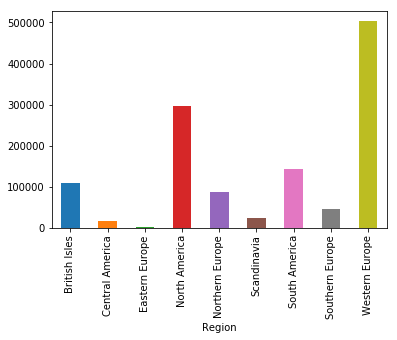

In [167]:
df.groupby('Region')['Revenue'].sum().plot.bar()

In [168]:
df.groupby('Region')['Revenue'].agg(['min','max','sum','mean'])

,min,max,sum,mean
Region,,,,
British Isles,4.80,9903.2,108951.2150,573.427447
Central America,20.80,3952.5,16558.1000,301.056364
Eastern Europe,22.35,591.6,3531.9500,220.746875
North America,14.00,10540.0,295780.9005,692.695317
Northern Europe,14.40,10540.0,87156.1625,609.483654
Scandinavia,17.88,2108.0,24545.2025,350.645750
South America,8.64,15810.0,142677.8080,469.334895
Southern Europe,7.30,2475.8,45225.7175,330.114726
Western Europe,8.50,15019.5,503548.4085,684.169033


9 Regions have quite different total revenue at a glance with Western Europe being the top driver, following by North America. However, some regions have close average revenue per customer such as Western Europe and North America. Looking at avg revenue per customer helps the company evalute types of business in the region: Small - Meidum Business vs Enterprise

In [169]:
#Number of Customers by Region 
df.groupby('Region')['CustomerId'].count()

Region
British Isles      190
Central America     55
Eastern Europe      16
North America      427
Northern Europe    143
Scandinavia         70
South America      304
Southern Europe    137
Western Europe     736
Name: CustomerId, dtype: int64

**Two ways of looking at regions**
- Divide 9 regions to 5 bigger regions: Western & Eastern Europe; Northern & Southern Europe; British Isles & Scandinavia; North America; Central & South America
- Divide 9 regions to 2 parts: Europe, Americas

In [171]:
df.head()

,CustomerId,Region,UnitPrice,Quantity,Discount,Revenue
0,VINET,Western Europe,14.0,12,0.0,168.0
1,VINET,Western Europe,9.8,10,0.0,98.0
2,VINET,Western Europe,34.8,5,0.0,174.0
3,TOMSP,Western Europe,18.6,9,0.0,167.4
4,TOMSP,Western Europe,42.4,40,0.0,1696.0


In [175]:
df.loc[(df.Region == 'Western Europe') | (df.Region == 'Eastern Europe'), 'NewRegion'] = 'W & E Europe'
df.loc[(df.Region == 'Northern Europe') | (df.Region == 'Southern Europe'), 'NewRegion'] = 'N & S Europe'
df.loc[(df.Region == 'British Isles') | (df.Region == 'Scandinavia'), 'NewRegion'] = 'British Isles & Scandinavia'
df.loc[df.Region == 'North America' , 'NewRegion'] = 'North America'
df.loc[(df.Region == 'Central America') | (df.Region == 'South America'), 'NewRegion'] = 'C & S America'

In [176]:
df.loc[(df.NewRegion == 'W & E Europe') | (df.NewRegion == 'N & S Europe') | (df.NewRegion == 'British Isles & Scandinavia'), 'Area'] = 'Europe'
df.loc[(df.NewRegion == 'North America') | (df.NewRegion == 'C & S America'), 'Area'] = 'Americas'

In [177]:
df.groupby('Region')['NewRegion'].count()

Region
British Isles      190
Central America     55
Eastern Europe      16
North America      427
Northern Europe    143
Scandinavia         70
South America      304
Southern Europe    137
Western Europe     736
Name: NewRegion, dtype: int64

In [178]:
df.groupby('NewRegion')['Revenue'].agg(['min','max','sum','mean','count'])

,min,max,sum,mean,count
NewRegion,,,,,
British Isles & Scandinavia,4.80,9903.2,133496.4175,513.447760,260
C & S America,8.64,15810.0,159235.9080,443.554061,359
N & S Europe,7.30,10540.0,132381.8800,472.792429,280
North America,14.00,10540.0,295780.9005,692.695317,427
W & E Europe,8.50,15019.5,507080.3585,674.308987,752


In [187]:
sub_df = df[['NewRegion','Revenue']]

### 2.3 Hypothesis Test

In [194]:
#Construct Test datasets: W&E Europe - E1, N&S Europe - E2, British & Scandinavia - E3, North America - A1, C&S America - A2
E1 = sub_df[sub_df['NewRegion']=='W & E Europe']['Revenue']
E2 = sub_df[sub_df['NewRegion']=='N & S Europe']['Revenue']
E3 = sub_df[sub_df['NewRegion']=='British Isles & Scandinavia']['Revenue']
A1 = sub_df[sub_df['NewRegion']=='North America']['Revenue']
A2 = sub_df[sub_df['NewRegion']=='C & S America']['Revenue']

Text(0.5, 1.0, 'Distribution of Revenue by Region')

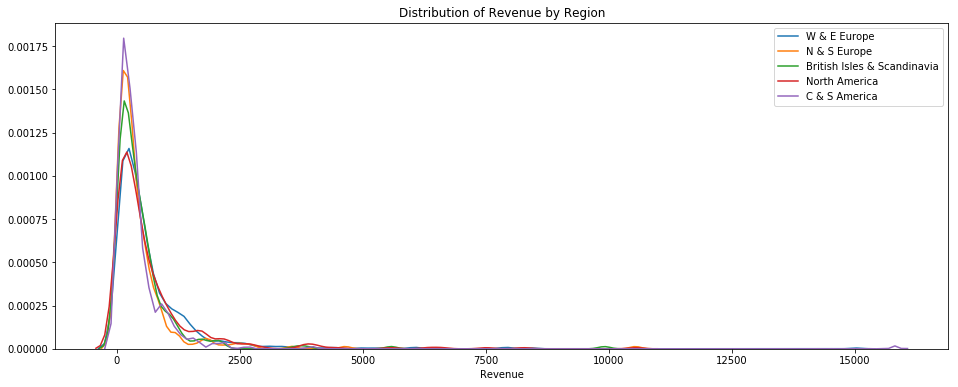

In [200]:
#Plot the distributions of 5 regions

plt.figure(figsize=(16,6))
ax = sns.distplot(E1, hist=False, label='W & E Europe')
ax = sns.distplot(E2, hist=False, label='N & S Europe')
ax = sns.distplot(E3, hist=False, label='British Isles & Scandinavia')
ax = sns.distplot(A1, hist=False, label='North America')
ax = sns.distplot(A2, hist=False, label='C & S America')
plt.title('Distribution of Revenue by Region')

Not normally distributed. However, the sample size is large enough. 

### Test of Equal Variance

Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

In [202]:
stats.levene(E1,E2,E3,A1,A2, center='mean')

LeveneResult(statistic=6.967192914829611, pvalue=1.4370398126083202e-05)

The Pvalue is < alpha(0.05), so we can reject the null hypothesis that both samples are from populations with equal variance. Therefore, we have to use non-parametric Krusal-Wallis Test 

### Krusal-Wallis Test

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post-hoc comparisons between groups are required to determine which groups are different.

In [203]:
stats.kruskal(E1, E2, E3, A1, A2)

KruskalResult(statistic=49.93763885917185, pvalue=3.720760437171133e-10)

P-value is < alpha (0.05), therefore we can reject the null. There is significant difference in the average revenue in 5 regions. 

group1,group2,meandiff,lower,upper,reject
British Isles & Scandinavia,C & S America,-69.8937,-285.7023,145.9149,False
British Isles & Scandinavia,N & S Europe,-40.6553,-268.8937,187.583,False
British Isles & Scandinavia,North America,179.2476,-29.2184,387.7135,False
British Isles & Scandinavia,W & E Europe,160.8612,-29.7955,351.5179,False
C & S America,N & S Europe,29.2384,-182.0529,240.5296,False
C & S America,North America,249.1413,59.38,438.9025,True
C & S America,W & E Europe,230.7549,60.7513,400.7586,True
N & S Europe,North America,219.9029,16.117,423.6888,True
N & S Europe,W & E Europe,201.5166,15.9886,387.0445,True
North America,W & E Europe,-18.3863,-178.9663,142.1937,False


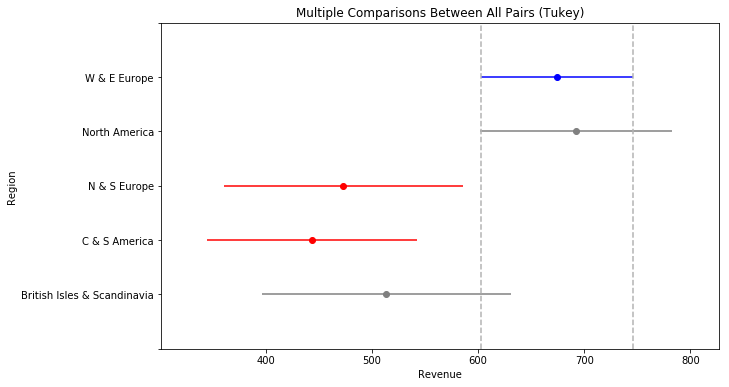

In [212]:
#Tukey's HSD post-hoc comparisons
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

com = MultiComparison(df['Revenue'], df['NewRegion'])
tukey = com.tukeyhsd()
tukey.plot_simultaneous(comparison_name='W & E Europe', xlabel='Revenue', ylabel='Region')
tukey.summary()


plot_intervals will color code all groups that are significantly different from the comparison_name red, and will color code insignificant groups gray. Otherwise, all intervals will just be plotted in black.

Conclusion: The average revenue of W&E Europe and North American is not significantly different

In [63]:
product = df_sql(
"""
SELECT * FROM Product

""")

In [64]:
product.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [65]:
#Join Product and Category

category = df_sql("""
SELECT * FROM Category
""")
category.head()

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [84]:
df = df_sql(
"""
SELECT * FROM

(SELECT D.ProductId, D.UnitPrice, D.Quantity, D.Discount, E.ID AS OrderId, E.ShipRegion, E.ShipCity, E.ShipCountry  FROM 'OrderDetail' AS D
LEFT JOIN 'Order'AS E
ON D.OrderId = E.Id) O

LEFT JOIN

(SELECT * FROM product
LEFT JOIN Category
ON product.CategoryId = Category.Id) P
ON 
O.ProductId = P.Id

""")


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 21 columns):
ProductId          2155 non-null int64
UnitPrice          2155 non-null float64
Quantity           2155 non-null int64
Discount           2155 non-null float64
OrderId            2155 non-null int64
ShipRegion         2155 non-null object
ShipCity           2155 non-null object
ShipCountry        2155 non-null object
Id                 2155 non-null int64
ProductName        2155 non-null object
SupplierId         2155 non-null int64
CategoryId         2155 non-null int64
QuantityPerUnit    2155 non-null object
UnitPrice          2155 non-null float64
UnitsInStock       2155 non-null int64
UnitsOnOrder       2155 non-null int64
ReorderLevel       2155 non-null int64
Discontinued       2155 non-null int64
Id:1               2155 non-null int64
CategoryName       2155 non-null object
Description        2155 non-null object
dtypes: float64(3), int64(11), object(7)
memory usage: 353.6+

In [87]:
df = df.drop(columns=['Id','Id:1'])

In [95]:
regions = df['ShipRegion'].unique()

Text(0.5, 1.0, 'Quantity by Categories in Western Europe')
Text(0.5, 1.0, 'Quantity by Categories in South America')
Text(0.5, 1.0, 'Quantity by Categories in Central America')
Text(0.5, 1.0, 'Quantity by Categories in North America')
Text(0.5, 1.0, 'Quantity by Categories in Northern Europe')
Text(0.5, 1.0, 'Quantity by Categories in Scandinavia')
Text(0.5, 1.0, 'Quantity by Categories in Southern Europe')
Text(0.5, 1.0, 'Quantity by Categories in British Isles')
Text(0.5, 1.0, 'Quantity by Categories in Eastern Europe')


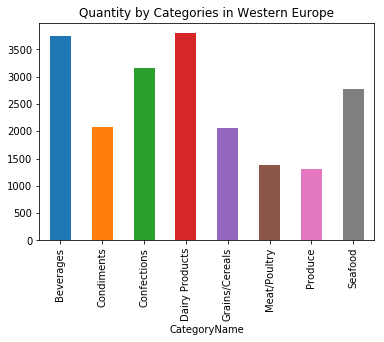

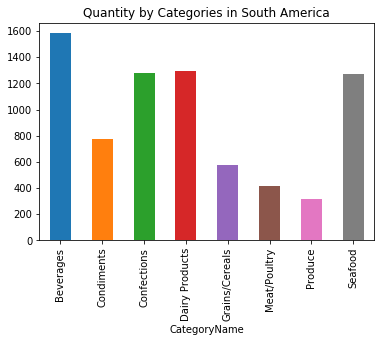

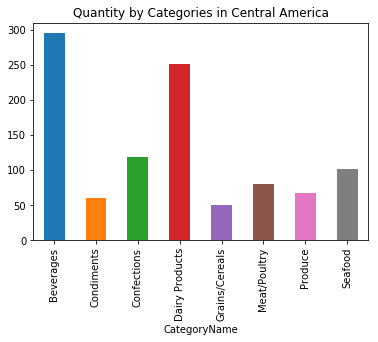

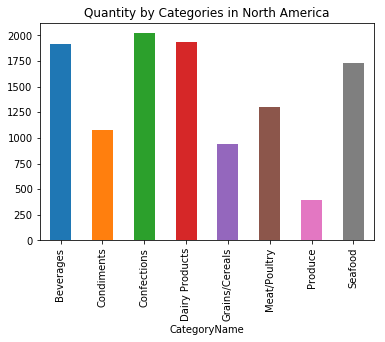

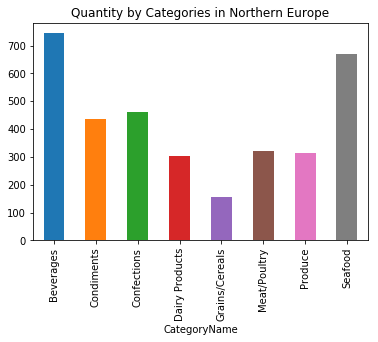

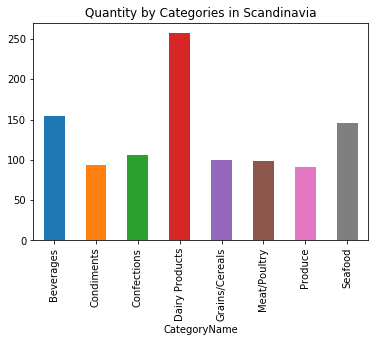

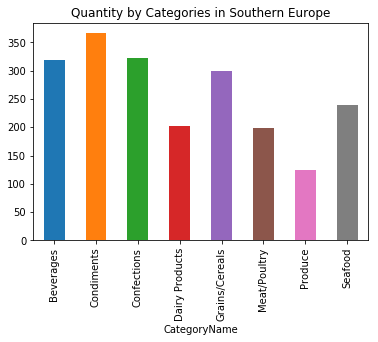

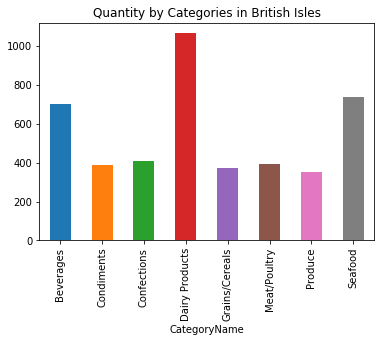

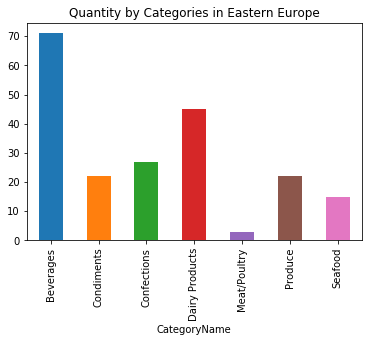

In [106]:
#Explore category within each region
for i in regions:
    
    x = df[df['ShipRegion']==i]
    plt.figure()
    x.groupby('CategoryName')['Quantity'].sum().plot.bar()
    print(plt.title("Quantity by Categories in " + i))

    

In [90]:
West_Europe = df[df['ShipRegion']=='Western Europe']

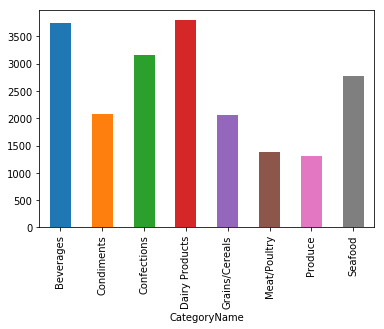

In [92]:
West_Europe.groupby('CategoryName')['Quantity'].sum().plot.bar()

In [47]:
df['ShipRegion'].nunique()

9

In [51]:
df['Region'].nunique()

2

## Does Seasonality impact Sales?
- Does seasonality impact all sales?
- Does seasonality impact all regions?
- Does seasonality impact all categories? If so, what is our stategy? 
